In [ ]:
#colab drive 연결

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import library
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from scipy.signal import butter, lfilter




In [ ]:
# filter 관련 함수

# Function to apply low-pass filter (optional)
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

In [ ]:
#window segmenting

# Parameters for sliding window segmentation
window_size = 52  # 1 second at 52 Hz; adjust as needed
overlap_ratio = 0.75  # 75% overlap
stride = int(window_size * (1 - overlap_ratio))  # Calculate stride based on overlap ratio

# Define the sliding window segmentation function
def sliding_window_segments(data, window_size, stride):
    segments = []
    for start in range(0, len(data) - window_size + 1, stride):
        end = start + window_size
        segments.append(data[start:end])
    return np.array(segments)


In [ ]:

# Paths to the folders containing CSV files
squats_folder = '/content/drive/MyDrive/Colab Notebooks/exercise_classification/squat'
pushups_folder = '/content/drive/MyDrive/Colab Notebooks/exercise_classification/pushup'
pullups_folder = '/content/drive/MyDrive/Colab Notebooks/exercise_classification/pullup'
lunges_folder = '/content/drive/MyDrive/Colab Notebooks/exercise_classification/lunge'
non_workouts_folder = '/content/drive/MyDrive/Colab Notebooks/exercise_classification/non_workout'


# Map classes to labels
class_mapping = {
    'squats': 0,
    'pushups': 1,
    'pullups':2,
    'lunges':3,
    'non_workouts':4
}

# Get list of all CSV files in each folder
squats_files = glob.glob(os.path.join(squats_folder, '*.csv'))
pushups_files = glob.glob(os.path.join(pushups_folder, '*.csv'))
pullups_files = glob.glob(os.path.join(pullups_folder, '*.csv'))
lunges_files = glob.glob(os.path.join(lunges_folder, '*.csv'))
non_workouts_files = glob.glob(os.path.join(non_workouts_folder, '*.csv'))


print(f'Found {len(squats_files)} squat files.')
print(f'Found {len(pushups_files)} pushup files.')
print(f'Found {len(pullups_files)} pullup files.')
print(f'Found {len(lunges_files)} lunge files.')
print(f'Found {len(non_workouts_files)} non_workout files.')

# Combine file paths and labels
file_paths = []
labels = []

# Add squat files and labels
for file_path in squats_files:
    file_paths.append(file_path)
    labels.append(class_mapping['squats'])

# Add pushup files and labels
for file_path in pushups_files:
    file_paths.append(file_path)
    labels.append(class_mapping['pushups'])


for file_path in pullups_files:
    file_paths.append(file_path)
    labels.append(class_mapping['pullups'])

for file_path in lunges_files:
    file_paths.append(file_path)
    labels.append(class_mapping['lunges'])

for file_path in non_workouts_files:
    file_paths.append(file_path)
    labels.append(class_mapping['non_workouts'])

# Required columns in the CSV files
required_columns = ['aX1','aY1' ,'aZ1','gX1', 'gY1','gZ1', 'aX2', 'aY2','aZ2', 'gX2', 'gY2','gZ2']

# Collect data from all files for fitting the scaler
all_data = []


for file_path in file_paths:
    df = pd.read_csv(file_path)
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"The CSV file {file_path} must contain the following columns: {required_columns}")

    rows_to_delete = []
    values = df[required_columns].values


    for index, value in enumerate(values):
      if value[0] == 'aX':
        rows_to_delete.append(index)
        continue

    filtered_values = np.delete(values, rows_to_delete , axis=0)

    rows_to_delete = []

    numeric_values = filtered_values.astype(float)


    for index, value in enumerate(numeric_values):


      if np.isnan(value).any():
        rows_to_delete.append(index)


    filtered_values = np.delete(numeric_values, rows_to_delete , axis=0)
    #print(filtered_values)

    #nan check!!!!!!
    if np.isnan(filtered_values).any():
      print(file_path)


    data = filtered_values
    all_data.append(data)



Found 40 squat files.
Found 40 pushup files.
Found 20 pullup files.
Found 38 lunge files.
Found 87 non_workout files.


In [ ]:
# Concatenate all data to fit the scaler
concatenated_data = np.vstack(all_data)


# Function to process a single CSV file
def process_csv_file(file_path, required_columns, scaler=None, apply_filter=False, cutoff=5, fs=50):
    """
    Process a single CSV file.
    :param file_path: Path to the CSV file.
    :param required_columns: List of required columns.
    :param scaler: Scaler object for normalization.
    :param apply_filter: Whether to apply low-pass filter.
    :param cutoff: Cutoff frequency for low-pass filter.
    :param fs: Sampling frequency.
    :return: Processed data array.
    """
    df = pd.read_csv(file_path)

    # Ensure required columns are present
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"The CSV file {file_path} must contain the following columns: {required_columns}")

    # Extract the required columns
    data = df[required_columns].values

    rows_to_delete = []


    for index, value in enumerate(data):
      if value[0] == 'aX':
        rows_to_delete.append(index)
        continue

    filtered_values = np.delete(data, rows_to_delete , axis=0)

    rows_to_delete = []

    numeric_values = filtered_values.astype(float)



    for index, value in enumerate(numeric_values):
      if np.isnan(value).any():
        rows_to_delete.append(index)

    data = np.delete(numeric_values, rows_to_delete , axis=0)


    #nan check!!!!!!
    if np.isnan(data).any():
      print(file_path)


    # Optionally apply a low-pass filter to each column
    if apply_filter:
        for i in range(data.shape[1]):
            data[:, i] = butter_lowpass_filter(data[:, i], cutoff=cutoff, fs=fs)

    return data




# Process all files and collect segmented sequences and labels
sequence_list = []
label_list = []

for file_path, label in zip(file_paths, labels):
    data = process_csv_file(
        file_path,
        required_columns=required_columns,
        #scaler=scaler,
        apply_filter=True,  # Set to True to apply low-pass filter
        cutoff=5,            # Adjust cutoff frequency as needed
        fs=50                # Sampling frequency, adjust as per your data
    )

    # Apply window segmentation
    segments = sliding_window_segments(data, window_size, stride)
    sequence_list.extend(segments)  # Collect segmented sequences
    label_list.extend([label] * len(segments))  # Assign label to each segment

# Determine the maximum sequence length
max_sequence_length = 200  # Fixed max sequence length for padding #52로 바꾸면

# Pad or truncate sequences to the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(
    sequence_list,
    maxlen=max_sequence_length,
    dtype='float32',
    padding='post',  # Pad at the end
    truncating='post'  # Truncate at the end
)

# Convert labels to a NumPy array
y = np.array(label_list)

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Convert labels to categorical (one-hot encoding)
num_classes = len(class_mapping)
y_categorical = utils.to_categorical(y, num_classes=num_classes)

# Split data into training, validation, and test sets (8:1:1 ratio)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_categorical, test_size=0.1, random_state=42, stratify=y
)

validation_size = 0.1111  # Validation should be ~10% of original data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=validation_size, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')

# Define the TCN model (existing code continues as is)...


Training samples: 20271
Validation samples: 2534
Test samples: 2534


In [ ]:
if np.isnan(X).any():
    print("NaN values found in X")
else:
    print("No NaN values in X")

No NaN values in X


In [ ]:


def build_tcn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    num_filters = 16
    kernel_size = 3
    num_levels = 1  # Number of residual blocks

    for i in range(num_levels):
        dilation_rate = 2 ** i
        x_prev = x
        # First Conv1D layer
        x = layers.Conv1D(filters=num_filters, kernel_size=kernel_size,
                          padding='causal', dilation_rate=dilation_rate)(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)
        # Second Conv1D layer
        x = layers.Conv1D(filters=num_filters, kernel_size=kernel_size,
                          padding='causal', dilation_rate=dilation_rate)(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)
        # Residual connection
        if x_prev.shape[-1] != num_filters:
            x_prev = layers.Conv1D(filters=num_filters, kernel_size=1, padding='same')(x_prev)
        x = layers.add([x, x_prev])

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model




In [ ]:

# Build the model
input_shape = X_train.shape[1:]  # (max_sequence_length, num_features)
model = build_tcn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_loss',
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 200, 12)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 200, 16)        │            592 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 200, 16)        │             32 │ conv1d_21[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 200, 16)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_22 (Conv1D)        │ (None, 200, 16)        │            784 │ re_lu_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 200, 16)        │             32 │ conv1d_22[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)           │ (None, 200, 16)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 200, 16)        │            208 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 200, 16)        │              0 │ re_lu_15[0][0],        │
│                           │                        │                │ conv1d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 16)             │              0 │ add_7[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 5)              │             85 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,733 (6.77 KB)

 Trainable params: 1,733 (6.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4689 - loss: 2.2005 - val_accuracy: 0.7115 - val_loss: 0.9075
Epoch 2/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7496 - loss: 0.8176 - val_accuracy: 0.8552 - val_loss: 0.6010
Epoch 3/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8637 - loss: 0.5423 - val_accuracy: 0.8891 - val_loss: 0.4278
Epoch 4/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8827 - loss: 0.4124 - val_accuracy: 0.8974 - val_loss: 0.3622
Epoch 5/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8974 - loss: 0.3443 - val_accuracy: 0.9081 - val_loss: 0.3071
Epoch 6/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9137 - loss: 0.2921 - val_accuracy: 0.9088 - val_loss: 0.2887
Epoch 7/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9123 - loss: 0.2838 - val_accuracy: 0.9183 - val_loss: 0.2480
Epoch 8/100
634/634 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9251 - loss: 0.2454 - val_accu

In [ ]:
print(input_shape)

(200, 12)


In [ ]:
X_test.shape
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 200, 12)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 200, 16)        │            592 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 200, 16)        │             32 │ conv1d_21[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 200, 16)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_22 (Conv1D)        │ (None, 200, 16)        │            784 │ re_lu_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 200, 16)        │             32 │ conv1d_22[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)           │ (None, 200, 16)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 200, 16)        │            208 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 200, 16)        │              0 │ re_lu_15[0][0],        │
│                           │                        │                │ conv1d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 16)             │              0 │ add_7[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 5)              │             85 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,201 (20.32 KB)

 Trainable params: 1,733 (6.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,468 (13.55 KB)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9744 - loss: 0.0810
Test Accuracy: 97.32%
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[ 395    0    0    7    2]
 [   1  317    0    2   13]
 [   1    0  174    0    1]
 [   6    3    0  444    9]
 [   6    6    1   10 1136]]
Classification Report:
              precision    recall  f1-score   support

      squats       0.97      0.98      0.97       404
     pushups       0.97      0.95      0.96       333
     pullups       0.99      0.99      0.99       176
      lunges       0.96      0.96      0.96       462
non_workouts       0.98      0.98      0.98      1159

    accuracy                           0.97      2534
   macro avg       0.97      0.97      0.97      2534
weighted avg       0.97      0.97      0.97      2534



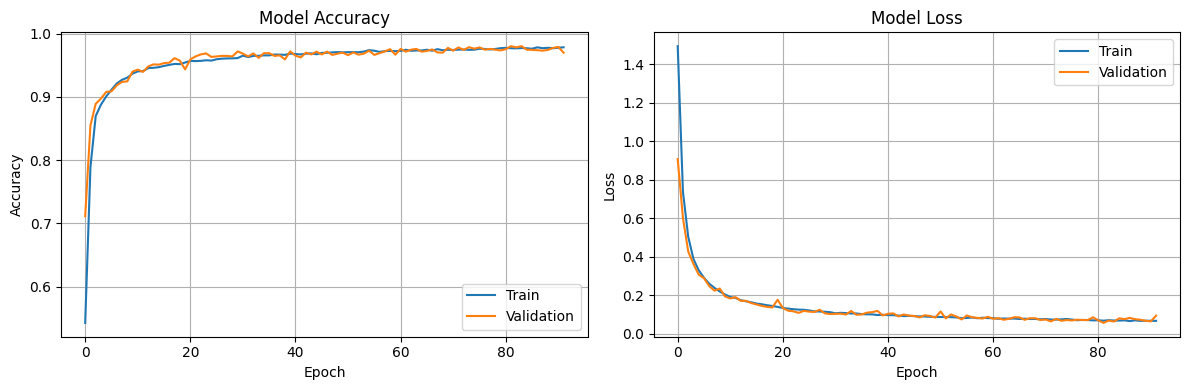

Model saved to /content/drive/MyDrive/TCN_Trained_Model_Data/tcn_workout_model_1220_7.h5


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Import additional metrics
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=class_mapping.keys())
print('Classification Report:')
print(class_report)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the model
model_save_path = '/content/drive/MyDrive/TCN_Trained_Model_Data/tcn_workout_model_1220_7.h5'
model.save(model_save_path)
print(f'Model saved to {model_save_path}')


In [ ]:
# If you have your model in Google Drive, mount it here.
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import os

# Path to your trained .h5 model file
model_path = '/content/drive/MyDrive/TCN_Trained_Model_Data/tcn_workout_model_1220_7.h5'
output_tflite_path = '/content/drive/MyDrive/TCN_Trained_Model_Data/tcn_workout_model_1220_7.tflite'

# Load the trained Keras model
model = tf.keras.models.load_model(model_path)

# Convert the model to TFLite without optimization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open(output_tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {output_tflite_path}")

# Optional: Quantization example (uncomment and adjust if needed)
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quant_model = converter.convert()

# quant_tflite_path = '/content/drive/MyDrive/TCN_Workout_Data/tcn_workout_model_1203_2_quantized.tflite'
# with open(quant_tflite_path, 'wb') as f:
#     f.write(tflite_quant_model)

# print(f"Quantized TFLite model saved at: {quant_tflite_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saved artifact at '/tmp/tmpke6zpef7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 12), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135362145046896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145051824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145055520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145057808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145057280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145079664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145079136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145079840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145082832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145078960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362145078784: 